In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers import Input, ZeroPadding2D,concatenate, Activation, Dropout, Flatten, GlobalAveragePooling2D, Dense, GlobalMaxPooling2D, UpSampling2D, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
# from keras.utils import np_utils
from keras import optimizers, regularizers
# from livelossplot.keras import PlotLossesCallback
# import efficientnet.keras as efn
import h5py, glob
import numpy as np
import itertools
from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

np.random.seed(1)


In [3]:
import cv2
import glob
import numpy as np
np.random.seed(1)
from sklearn.model_selection import train_test_split

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# **Load Data from Pickle File**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pickle

In [7]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [8]:
# [train_images, train_labels, test_images, test_labels] = load_pkl('/mnt/HDD04/Fall_2022/dataset_15_class/15_class_dataset.pkl')
[train_images, train_labels, test_images, test_labels] = load_pkl('/content/drive/MyDrive/Colab Notebooks/RadarChallenge/spectrogram/window_len/drone_dataset_winLen.pkl')
# train_images = train_images.astype(np.float64)
# test_images = test_images.astype(np.float64)
# train_labels = np.argmax(train_labels, -1)
# test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(21, 3, 128, 128)
(21, 4)
(15, 3, 128, 128)
(15, 4)


In [9]:
train_images = np.swapaxes(train_images, 1, 3)
test_images = np.swapaxes(test_images, 1, 3)

In [10]:
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

In [11]:
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (21, 4)
Y_test shape: (15, 4)


## Encoder and Decoder

In [12]:
# Here's two different encoder and decoder segment.we're using either of them.

def encoder77(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv02 = Conv2D(8, (9, 9), activation='relu', padding='same')(input_img)
    out01  = concatenate([conv01,conv02],axis=-1)
    pool01 = MaxPooling2D(pool_size=(4, 4))(out01) #14 x 14 x 32, 64x64x8

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool01) # 128x128x8
    conv2 = Conv2D(16, (9, 9), activation='relu', padding='same')(pool01)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(out1) #14 x 14 x 32, 64x64x8

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16

    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) # 64x64x16
    conv6 = Conv2D(64, (9, 9), activation='relu', padding='same')(pool2)
    out3  = concatenate([conv5,conv6],axis=-1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(out3) # 4x4x32

    return pool3

def decoder77(pool3):
    #decoder
    conv7 = Conv2D(64, (9, 9), activation='relu', padding='same')(pool3) # 16x16x16
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    out4  = concatenate([conv7,conv8], axis=-1)
    up1   = UpSampling2D((2,2))(out4) # 64x64x16


    conv9 = Conv2D(32, (9, 9), activation='relu', padding='same')(up1) # 16x16x16
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16

    conv11 = Conv2D(16, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12], axis=-1)
    up3 = UpSampling2D((2,2))(out6) #  128x128x8

    conv17 = Conv2D(8, (9, 9), activation='relu', padding='same')(up3) # 64x64x8
    conv18 = Conv2D(8, (3, 3), activation='relu', padding='same')(up3)
    out7  = concatenate([conv17,conv18], axis=-1)
    up5 = UpSampling2D((4,4))(out7) #  128x128x8

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up5) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    return decoded

def encoder6(input_img):

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv2 = Conv2D(16, (9, 9), activation='relu', padding='same')(input_img)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(out1) #14 x 14 x 32, 64x64x8

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16

    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) # 16x16x32
    conv6 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool2)
    out3  = concatenate([conv5,conv6],axis=-1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(out3) # 4x4x32  (small and thick)

    return pool3

def decoder6(pool3):


    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool3) # 4x4x32
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    out4  = concatenate([conv7,conv8], axis=-1)
    up1   = UpSampling2D((2,2))(out4) #  16x16x32

    conv9 = Conv2D(32, (9, 9), activation='relu',  padding='same')(up1) # 16x16x16
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16

    conv11 = Conv2D(16, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12], axis=-1)
    up3 = UpSampling2D((4,4))(out6) #  128x128x8

    decoded = Conv2D(3, (3, 3),activation='sigmoid', padding='same')(up3) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    return decoded



In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
im_width = 128
im_height = 128
inChannel = 3
input_img = Input(shape = (im_width, im_height, inChannel))
autoencoder = Model(input_img, decoder77(encoder77(input_img)))
# define optimiz75
lr = 0.001
optim = Adam(lr=lr) # decay rate = 5e-06 for xethru
# autoencoder.compile(loss='categorical_crossentropy', optimizer = optim, metrics=['accuracy'])
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
# autoencoder_train = autoencoder.fit(X_train, X_train, validation_data = (X_test,X_test), batch_size=16,epochs=20, verbose=1, callbacks = [PlotLossesCallback()])
autoencoder_train = autoencoder.fit(X_train, X_train, validation_data = (X_test,X_test), batch_size=16,epochs=20, verbose=1)

Epoch 1/20
2/2 [==============================] - 21s 2s/step - loss: 0.1501 - accuracy: 0.1754 - val_loss: 0.0567 - val_accuracy: 0.9128
Epoch 2/20
2/2 [==============================] - 0s 62ms/step - loss: 0.0824 - accuracy: 0.9042 - val_loss: 0.1371 - val_accuracy: 0.9164
Epoch 3/20
2/2 [==============================] - 0s 55ms/step - loss: 0.1170 - accuracy: 0.9076 - val_loss: 0.0508 - val_accuracy: 0.9170
Epoch 4/20
2/2 [==============================] - 0s 60ms/step - loss: 0.0553 - accuracy: 0.9080 - val_loss: 0.0584 - val_accuracy: 0.9181
Epoch 5/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0590 - accuracy: 0.9093 - val_loss: 0.0520 - val_accuracy: 0.9180
Epoch 6/20
2/2 [==============================] - 0s 59ms/step - loss: 0.0547 - accuracy: 0.9088 - val_loss: 0.0457 - val_accuracy: 0.9167
Epoch 7/20
2/2 [==============================] - 0s 63ms/step - loss: 0.0480 - accuracy: 0.9077 - val_loss: 0.0450 - val_accuracy: 0.9164
Epoch 8/20
2/2 [============

In [15]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 8)          1952      ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128, 128, 16)         0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

## Auto-Encoder as classifier
#### Get rid of the decoder part and add bunch of fully connected layers

In [16]:
acc_hist = []
hist_hist = []
num_class=4

model2 = Model(input_img , outputs=autoencoder.layers[16].output)
model = Sequential()

model.add(model2)
# model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))# 256 for 77
model.add(Dropout(0.55))

model.add(Dense(256, activation='relu')) # 128 for 77
model.add(Dropout(0.55))

model.add(Dense(num_class))
model.add(Activation('softmax'))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.summary

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00008), metrics=["accuracy"])
# metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)]
history = model.fit(X_train, Y_train,
                batch_size=8,
                epochs=70,
                verbose=1,
                validation_data=(X_test, Y_test),

                shuffle=False,
                callbacks = [callback]
                     )
acc = history.history['val_accuracy'][-1]
acc_hist.append(acc)
hist_hist.append(history.history)



Epoch 1/70
3/3 [==============================] - 7s 547ms/step - loss: 1.4044 - accuracy: 0.1429 - val_loss: 1.3701 - val_accuracy: 0.2000
Epoch 2/70
3/3 [==============================] - 0s 43ms/step - loss: 1.0221 - accuracy: 0.6667 - val_loss: 1.3981 - val_accuracy: 0.2000
Epoch 3/70
3/3 [==============================] - 0s 41ms/step - loss: 0.7651 - accuracy: 0.7143 - val_loss: 1.4450 - val_accuracy: 0.2000
Epoch 4/70
3/3 [==============================] - 0s 38ms/step - loss: 0.6673 - accuracy: 0.8095 - val_loss: 1.4807 - val_accuracy: 0.3333
Epoch 5/70
3/3 [==============================] - 0s 51ms/step - loss: 0.5332 - accuracy: 0.9048 - val_loss: 1.5837 - val_accuracy: 0.1333
Epoch 6/70
3/3 [==============================] - 0s 51ms/step - loss: 0.2647 - accuracy: 0.9524 - val_loss: 1.8096 - val_accuracy: 0.1333
Epoch 7/70
3/3 [==============================] - 0s 51ms/step - loss: 0.4253 - accuracy: 0.8571 - val_loss: 2.1147 - val_accuracy: 0.1333
Epoch 8/70
3/3 [==========

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 4, 128)         486240    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [18]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print (" 4 Target Classes CAE = " + str(preds[1]))

1/1 [==============================] - 0s 32ms/step - loss: 3.2439 - accuracy: 0.1333
Loss = 3.243927478790283
 4 Target Classes CAE = 0.13333334028720856


# **Confusion Matrix**

In [19]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 168ms/step


In [20]:
Y_test = np.argmax(Y_test, axis=1)

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [22]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test, predictions , normalize='pred')

In [23]:
labels = ["Bird", "Heli", "Prop", "Quad"]

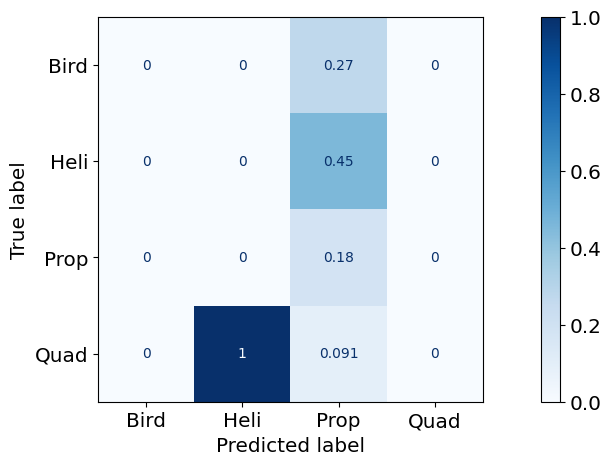

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()